In [1]:
import os
import cv2
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split as tt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report as cr

In [2]:


from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset = image_dataset_from_directory(
     r"C:\Users\hanal\Documents\Downloads\archive(2) (1)\17FlowerOxfordDataset",          # path to main folder
    image_size=(128, 128),           # resize images
    batch_size=32                    # batch size
)

class_names = dataset.class_names
print(class_names)


C:\Users\hanal\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\hanal\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\hanal\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

Found 645 files belonging to 7 classes.
['bluebell', 'daisy', 'dandelion', 'iris', 'pansy', 'tulip', 'windflower']


In [3]:
import numpy as np
import cv2
from skimage.feature import hog

features1 = []
labels_used = []

for batch_images, batch_labels in dataset:
    # batch_images shape: (batch_size, 128, 128, 3), dtype=tf.float32 (0-255 scaled)
    # batch_labels shape: (batch_size,)
    
    batch_images_np = batch_images.numpy().astype(np.uint8)  # convert to uint8
    
    for img, label in zip(batch_images_np, batch_labels.numpy()):
        # img is RGB, convert to BGR for OpenCV if needed
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # --- HSV Histogram ---
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                            [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # --- HOG Features ---
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        combined = np.hstack([hist, hog_feat])
        features1.append(combined)
        labels_used.append(label)


In [14]:
# pip install scikit-image

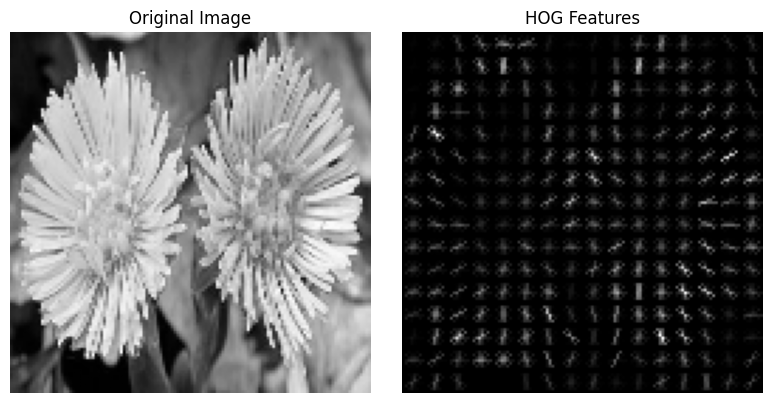

In [4]:
import numpy as np

# Flatten batches into a list of images
images = []
labels = []

for batch_images, batch_labels in dataset:
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())

# Now pick the 20th image (index 19)
img_tf = images[80]  # shape (128, 128, 3), dtype float32 (0-255)
import cv2

img_np = img_tf.astype(np.uint8)          # convert to uint8
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # convert RGB to BGR (OpenCV uses BGR)
from skimage.feature import hog
import matplotlib.pyplot as plt

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # grayscale

# Resize if needed (already 128x128 but can resize to be sure)
gray = cv2.resize(gray, (128, 128))

features, hog_image = hog(
    gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=None
)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
X = np.array(features1)
y = np.array(labels_used)

x_train, x_test, y_train, y_test = tt(X, y, test_size=0.2)

# You can try either classifier:
# Naive Bayes
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(cr(y_test, y_pred_nb, target_names=class_names))

Naive Bayes Accuracy: 0.7364341085271318
              precision    recall  f1-score   support

    bluebell       0.82      0.58      0.68        24
       daisy       1.00      0.62      0.77        16
   dandelion       0.88      0.79      0.84        29
        iris       0.81      0.68      0.74        19
       pansy       0.57      0.92      0.71        13
       tulip       0.38      0.67      0.48         9
  windflower       0.74      0.89      0.81        19

    accuracy                           0.74       129
   macro avg       0.74      0.74      0.72       129
weighted avg       0.79      0.74      0.74       129



In [6]:
sv = SVC()
sv.fit(x_train, y_train)
y_pred_svm = sv.predict(x_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(cr(y_test, y_pred_svm, target_names=class_names))

SVM Accuracy: 0.5581395348837209
              precision    recall  f1-score   support

    bluebell       1.00      0.12      0.22        24
       daisy       0.75      0.56      0.64        16
   dandelion       0.46      0.90      0.60        29
        iris       1.00      0.68      0.81        19
       pansy       0.54      0.54      0.54        13
       tulip       0.46      0.67      0.55         9
  windflower       0.44      0.42      0.43        19

    accuracy                           0.56       129
   macro avg       0.66      0.56      0.54       129
weighted avg       0.68      0.56      0.53       129



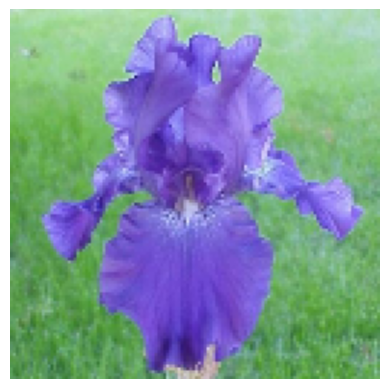

Predicted Class: iris


In [11]:

import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

# def preprocess_image(img_path):
#     # Load image (BGR)
#     img_bgr = cv2.imread(img_path)
#     img_bgr = cv2.resize(img_bgr, (128, 128))  # same size as training
    
#     # HSV histogram
#     hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
#     hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
#                         [0, 180, 0, 256, 0, 256])
#     hist = cv2.normalize(hist, hist).flatten()
    
#     # HOG features
#     gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
#     hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
#                    cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    
#     # Combine histogram + HOG
#     combined = np.hstack([hist, hog_feat])
#     return combined, img_bgr

def predict_image(img_path, model, class_names):
    features, img_bgr = preprocess_image(img_path)
    features = features.reshape(1, -1)
    predicted_label = model.predict(features)[0]
    predicted_class = class_names[predicted_label]
    
    # Show image
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
   
    plt.axis('off')
    plt.show()
    
    return predicted_class

# Example usage (for SVM):
img_path = r"C:\Users\hanal\Documents\Downloads\archive(2) (1)\17FlowerOxfordDataset\iris\image_0404.jpg"
pred_class = predict_image(img_path, sv, class_names)
print("Predicted Class:", pred_class)
